# Livrable 3 - Captioning

Sur ce dernier livrable nous présenterons les différents processus de captioning. L'objectif est de créer un réseau de neurones qui lorsqu'on lui donne en entrée une image arrive a générer une légendes la décrivant.
Pour ce faire nous utiliserons tout le long de ce livrable le dataset MS COCO de 2017.

Après quelques recherches sur le captioning, nous avons remarqué que dans la majorité des cas et afin d'avoir un fonctionnement optimal. Il est normal de décomposer notre réseau en deux parties. Une partie CNN qui permettra d'encoder les images. Et une autre qui sera un RNN qui utilisera la sortie du CNN et qui permettra de legender les images que nous lui donnerons.

# Sommaire

1. [Sommaire](#Sommaire)
2. [Imports et chargement des données](#Imports-et-chargement-des-donnees)
    * [Chargement des données](#Chargement-des-donnees)
    * [Pré-traitement des annotations](#Pre-traitement-des-annotations)
3. [Formation des jeux de données](#Formation-des-jeux-de-donnees)
4. [Le modèle](#Le-modele)
    * [L'encodeur CNN](#L'encodeur-CNN)
    * [Le mécanisme d'attention](#Le-mecanisme-d'attention) 
    * [Le décodeur RNN](#Le-decodeur-RNN)
    * [Préparation de l'entrainement](#Preparation-de-l'entrainement)
5. [Entrainement et Test](#Entrainement-et-Test)
    * [Entrainement](#Entrainement)
    * [Test](#Test)
6. [Mesurer l'efficacite du Captioning](#Mesurer-l'efficacite-du-Captioning)
    * [Problème](#Probleme)
    * [Proposition de solution](#Proposition-de-solution)
        * [Cémantix](#Cemantix)
        * [Métriques Bleues](#Metriques-Bleues)
        * [Imaginons un métrique](#Imaginons-un-metrique)
7. [Conclusion](#Conclusion)

# Imports et chargement des donnees

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

## Chargement des donnees

In [ ]:
# Chemin du fichier d'annotations
annotation_file = "/home/kieran/Projects/Datasets/COCO/datasets/annotations_trainval2017/annotations/captions_train2017.json"

# Chemin du dossier contenant les images à annoter
PATH = '/home/kieran/Projects/Datasets/COCO/datasets/train2017'

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = f"{PATH}/%012d.jpg" % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)
    
# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list))


Afin de classifier les images en entrée, nous utiliserons InceptionV3.
Tout comme présenter dans le livrable 1 avec VGG16, dans la section transfert learning.
Inception V3 est un modèle de reconnaissance d'image, lui également fut entrainé sur l'ensemble de données ImageNet.


In [ ]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = 'imagenet'
)
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input
# Récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.experimental.preprocessing.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))
# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
# Parcourir le dataset batch par batch pour effectuez le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
    # Pré-traitement du batch (de taille (16,8,8,2048)) courant par InceptionV3 
    batch_features = image_features_extract_model(img)
    # Resize du batch de taille (16,8,8,2048) en taille (16,64,2048)
    batch_features = tf.reshape(
        batch_features,
        (batch_features.shape[0], -1, batch_features.shape[3])
    )
    # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        # (chemin de l'image associe a sa nouvelle representation , representation de l'image)
        np.save(path_of_feature, bf.numpy())

2022-10-12 13:16:07.415570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:16:07.464942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:16:07.465210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-12 13:16:07.466154: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Pre-traitement des annotations

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs,
        r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~",
        ""
    )

# Nombre maximum de mots pour une légende.
max_length = 50
# Utilisez les 5000 premiers mots pour un vocabulaire.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length
)
# On utilise le vocabulaire à partir des données des légendes
tokenizer.adapt(caption_dataset)

cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Créez des correspondances pour les mots vers les index et les index vers les mots.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

# Formation des jeux de donnees

Tout comme les livrables précédents, nous séparons le dataset en deux partie.
La première partie sera notre jeu d'entrainement, ce dernier représente 80% du dataset que nous composons de façons aléatoire.
La seconde partie sera notre jeu de test afin d'évaluer notre captioning

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Création des deux ensembles
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8009, 8009, 2001, 2001)

On utilise une instance de tf.data.Dataset afin de représenter le jeu de données et pour faciliter le prétraitement

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# La forme du vecteur extrait de InceptionV3 est (64, 2048)
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
# Chargement des fichiers numpy
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor" (sert à representer de grands dataset)
# Le dataset est créé a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle et batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Le modele

## L'encodeur CNN


En sortie de InceptionV3 nous retrouvons un vecteur de forme (8, 8, 2048). Nous remodelons ce dernier afin d'obtenir un vecteur de la forme (64, 2048).
Ce dernier passe ensuite par l'encodeur CNN .Puis le RNN surveille l'image pour prédire le mot suivant. 

L'encodeur CNN permet de transformer nos images qu'il transmet ensuite au décodeur RNN pour que ce dernier les légendes.
En entrée du CNN nous retrouvons les caractéristiques des images prétraitées par InceptionV3 présenté plus-haut.
Contrairement aux présendants livrables, le CNN ne dispose pas de couche flatten, cela signifie que nous n'applatissons pas la dernière couche convolutive.

In [ ]:
class CNN_Encoder(tf.keras.Model):

    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## Le mecanisme d'attention



In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # Cette variable donne un score non-normalisé pour chaque image
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape après le sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## Le decodeur RNN

Commençons par une rapide présentation d'un RNN.
Un RNN est un type de réseau de neuronnes particulièrement utilisé dans le deep lerning pour plusieurs raisons.
L'avantage certain du RNN est qu'ils utilisent les sorties précédentes comme entrées.
En effet ils sont capables de gérer des séquences de vecteurs en entrés.
Les RNN sont utilisés dans beaucoup d'objets de notre quotidien, le dévérouillage téléphonique, les assistants vocals etc...
Par exemple pour une reconaissance vocale, le réseau de neuronnes arrive à comprendre les syllables actuel graçe à celles précédentes.

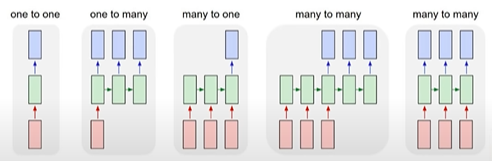

Par exemple avec l'architecture many to one, nous pouvons avoir en paramètre une série de mots, comme "je suis heureux" et avoir en sortie un booléen signifiant que la phrase est positive.

Le problème d'un RNN (The vanish gradient problem).

Lorsque l'on prend la dérivé partielle d'une focntion, généralement la fonction va se réduire/disparaitre (vanish) 
Par exemple pour une fonction sigmoid qui nous permet d'avoir une probabilité, lorsque les valeurs sont très petites ou sont très grandes, les valeurs de la dérivée partielle est également très petites.
Le problème se créé lorsque nous avons beaucoup d'opération qui se suivent. Car la multiplication de petits gradients va tendre vers 0 et ne serons donc plus capable de modifier les poids correctement.
Pour remédier à ce problème nous pouvons utiliser le LSTM.

Petite appartée **LSTM**.
Une cellule LSTM comporte trois opérations principales.


1.   Forget Gate: Capacité à oublier des informations qui ne sont plus utiles
2.   Input Gate: ajouter des informations 
3.   Output Gate: A partir des nouvelles informations sachant les informations que nous avons stocké quel est l'état de ma cellule à l'instant t.



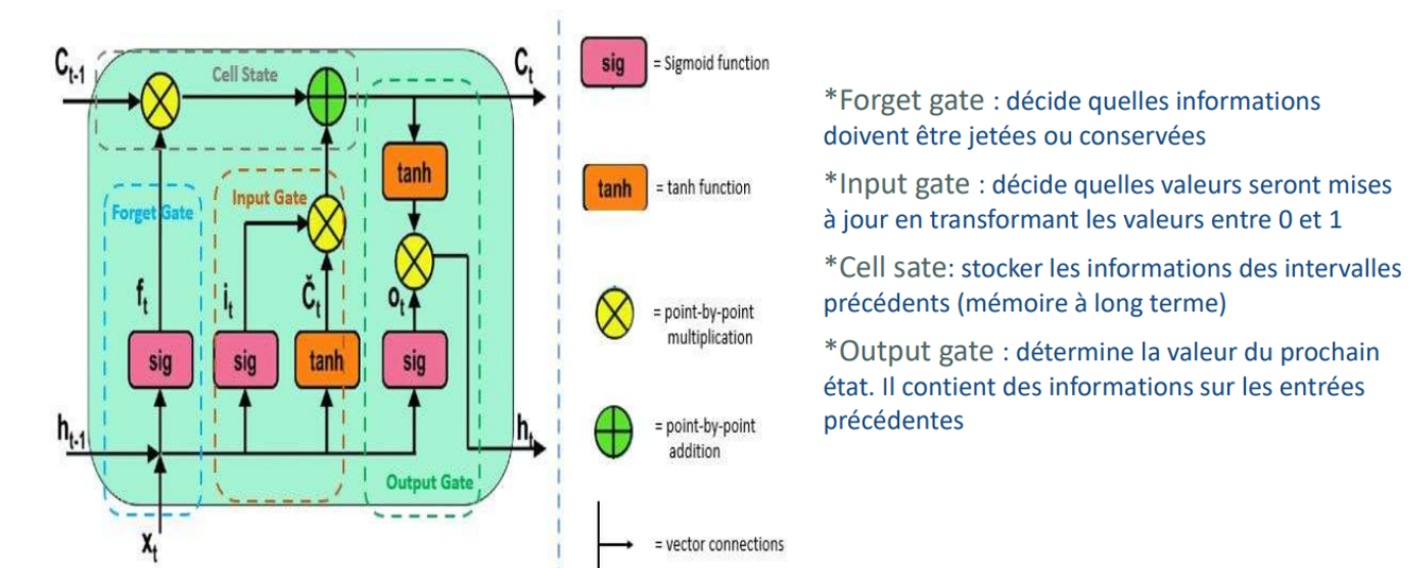

Les **GRU** tout commes les LSTM ont été créés comme la solution à la mémoire à court terme. Tout comme les LSTM les GRU disposent de gates qui peuvent réguler le flux d'informations.
Les GRU sont composés:


*   Reset gate: Elle permet de définir combien d'informations passé nous devons oublier et quelles nouvelles informations ajouter
*   Update gate: Elle permet de définir les informations à conserver et celles à oublier

Les GRU et les LSTM permettent d'obtenir des résultats comparable, néanmoins
les GRU sont moins conséquent qur les LSTM ce qui en fait une solution plus rapide, en effet ce dernier à moins de paramètre à calculer.



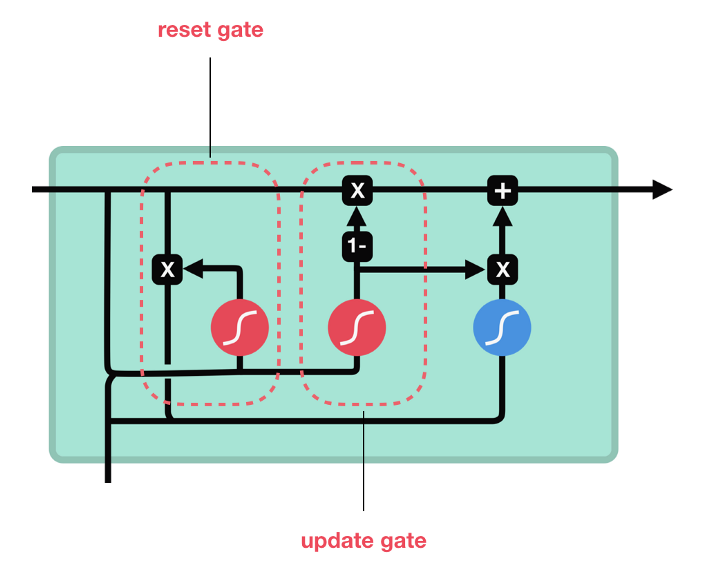

Notre décodeur est construit comme suit; 

L'image, l'état caché du Gru et le mot actuel sont en entrée de notre RNN.
Cependant les mots sont représentés par des entiers. Afin de tout de meme pouvoir calculer une représentation vectorielle nous passons par une couche d'embedding.
L'embedding est une représentations vectorielle continues, cette dernière est souvent un espace de faible dimension dans lequel nous pouvons traduire des vecteurs de grande dimension

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # Définir l'attention dans un modèle séparé
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape après l'embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape après la concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passer le vecteur concaténé à GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Preparation de l'entrainement


In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

La classe tf.train.checkpoint permet de sauvegarder notre apprentissage.

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Le code ci-dessous permet de poursuivre l'entrainement là ou il a été interrompu.

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Entrainement et Test

## Entrainement

Dans un premier temps, nous créons la fonction train_step. Cette fonction permet de calculer la perte d’un batch d’images prétraitées avec ses annotations associées. La variable dec_input permet de définir les dimensions des embedding. Dans un premier temps, nous lançons la fonction « encoder » pour récupérer les images encodées dans la variable features. Ensuite, nous utilisons la fonction « decoder » et nous récupérons la valeur de la loss.

A la fin, nous récupérons la valeur de loss du batch, la valeur de loss totale, les gradients sont calculés et le réseau est mise à jour.


In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Passage des features au décoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.

Au début, nous définissons le nombre d’époques que l’on souhaite avoir, puis, pour chaque époque, nous définissons la variable total_loss à 0. Ensuite, nous lançons la fonction d’entrainement train_step et nous récupérons la valeur de la loss du batch. À la fin, nous affichons la valeur de la loss totale.

Dans le cas ou la loss descend suffisamment, nous enregistrons les poids de l’époque.

In [ ]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # Sauvegarder l'époque et la loss pour pouvoir l'afficher
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 0.5316
Epoch 5 Batch 100 Loss 0.4364
Epoch 5 Loss 0.474511
Time taken for 1 epoch 75.22 sec

Epoch 6 Batch 0 Loss 0.4173
Epoch 6 Batch 100 Loss 0.4124
Epoch 6 Loss 0.400082
Time taken for 1 epoch 17.28 sec

Epoch 7 Batch 0 Loss 0.3814
Epoch 7 Batch 100 Loss 0.3565
Epoch 7 Loss 0.361403
Time taken for 1 epoch 17.34 sec

Epoch 8 Batch 0 Loss 0.3289
Epoch 8 Batch 100 Loss 0.3497
Epoch 8 Loss 0.337048
Time taken for 1 epoch 17.63 sec

Epoch 9 Batch 0 Loss 0.3005
Epoch 9 Batch 100 Loss 0.3187
Epoch 9 Loss 0.311011
Time taken for 1 epoch 17.54 sec

Epoch 10 Batch 0 Loss 0.2438
Epoch 10 Batch 100 Loss 0.2960
Epoch 10 Loss 0.289982
Time taken for 1 epoch 17.73 sec

Epoch 11 Batch 0 Loss 0.2522
Epoch 11 Batch 100 Loss 0.2609
Epoch 11 Loss 0.271305
Time taken for 1 epoch 17.66 sec

Epoch 12 Batch 0 Loss 0.2394
Epoch 12 Batch 100 Loss 0.2759
Epoch 12 Loss 0.256841
Time taken for 1 epoch 17.58 sec

Epoch 13 Batch 0 Loss 0.2377
Epoch 13 Batch 100 Loss 0.2309
Epoch 13 Loss 0.241

## Test

La fonction evalute va permettre de vérifier si notre modèle est performant. Il prend seulement en paramètre une image. Dans un premier temps, nous créons un tenseur de l’image, et nous le redimensionnons. Ensuite, nous encodons l’image. Puis, pour chaque mot que l’on souhaite prédire, nous entrons l’image dans le décoder et nous récupérons le mot prédit ainsi que les zones d’attentions retenues sur l’image. On ajoute ce mot à notre phrase. Si le mot prédit est le mot « end » alors la prédiction se termine. Une phrase ne peut pas faire plus de 50 mots.

La fonction plot_attention permet de représenter les zones d’attentions ainsi que le mot prédit qui lui correspond.

In [ ]:
# Fonction permettant d'avaluer le modèle
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

L'affichage de quelques exemples sur le résultat retourné par l'évaluation. 

Real Caption: <start> a chef in a kitchen with jars bowls and machines <end>
Prediction Caption: a man is playing a book in a party <end>


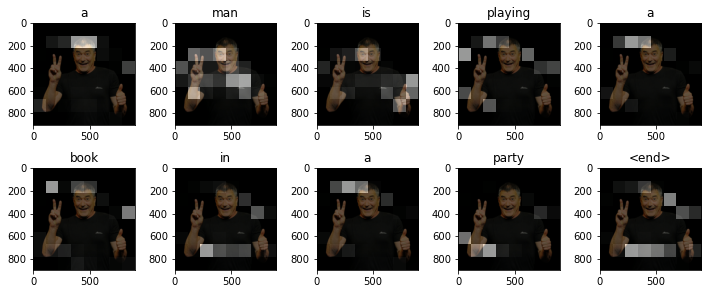

In [ ]:
# captions sur le jeu d'entrainement
rid = np.random.randint(0, len(img_name_val))
image = "/home/kieran/Téléchargements/photo.jpg"#img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

En faisant une petite comparaison entre l'annotation réelle et l'annotation prédite, nous nous rendons compte que les deux phrases sont assez proches l'une de l'autre. Nous pouvons donc hypothétiser que notre modèle a bien appris de notre jeu d'apprentissage.

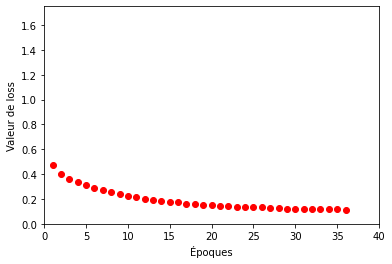

In [ ]:
loss = []
xAxis = []
i = 1
for los in loss_plot:
    loss.append(los.numpy())
    xAxis.append(i)
    i += 1

import matplotlib.pyplot as plt
plt.plot(xAxis, loss, 'ro')
plt.axis([0, EPOCHS, 0, 1.75])
plt.ylabel('Valeur de loss')
plt.xlabel('Époques')
plt.show()

Nous pouvons remarquer que le la loss du modèle se réduit au fur et à mesure des époques. Sa valeur actuelle est d'environ 0.1. Cependant, nous ne savons pas avec certitude si le modèle est performant. Nous avons besoin de connaitre des techniques afin de mesurer l'efficacité du Captioning.

# Mesurer l'efficacite du Captioning

## Probleme

Pour mesurer les performances d'un réseau de neurone pour la classification, il existe de multiples facteurs permettant de vérifier la validité d'une prédiction. Beaucoup d'entre eux sont basés sur les valeurs de la matrice de confusion : Accuracy, F1-score, Precision, etc.
<br /><br />
Or pour mesurer les performances d'un réseau effectuant du captioning, il n'existe pas de mesurer la corrélation entre deux phrases comme pour la classification.

## Proposition de solution
### Cemantix

[Cémantix](https://cemantix.certitudes.org/pedantix) est un jeu qui consiste à trouver un mot au hasard, dans le même style que le chaud ou froid. À chaque proposition de mot effectué, une note (en °C pour le chaud ou froid) est donnée à la proposition, ce score est lié au thème du mot.
<br /><br/>
Par exemple :
![](https://cdn.ordigeek.fr/Cementix.png)
<br /><br />
Nous pourrions prendre le même système en décomposant les mots des deux phrases (prédiction et l'attendue), par la suite, nous appliquerons un algorithme assez similaire à [Cémantix](https://cemantix.certitudes.org/pedantix) afin d'obtenir un score de corrélation. Dans le cas où il y a plusieurs noms, la corrélation la plus forte sera gardé en mémoire. À la suite, de ces actions, nous calculons une moyenne des scores dans le but d'obtenir un score sur l'ensemble de la phrase.
<br /><br />
Cependant, cette méthode nécessite un très grand nombre d'actions nécessaire en amont :
- Extraire le thème d'un mot.
- Trouvé les synonymes d'un mot.
- Organiser ces synonymes.
- Numériser l'organisation afin de pouvoir effectuer des calculs de corrélation par la suite.

### Metriques Bleues

Il est facile d'évaluer des algorithmes de classification, pour ce faire nous disposons de différentes métriques.

Petit rappel nous avons la matrice de confusion.
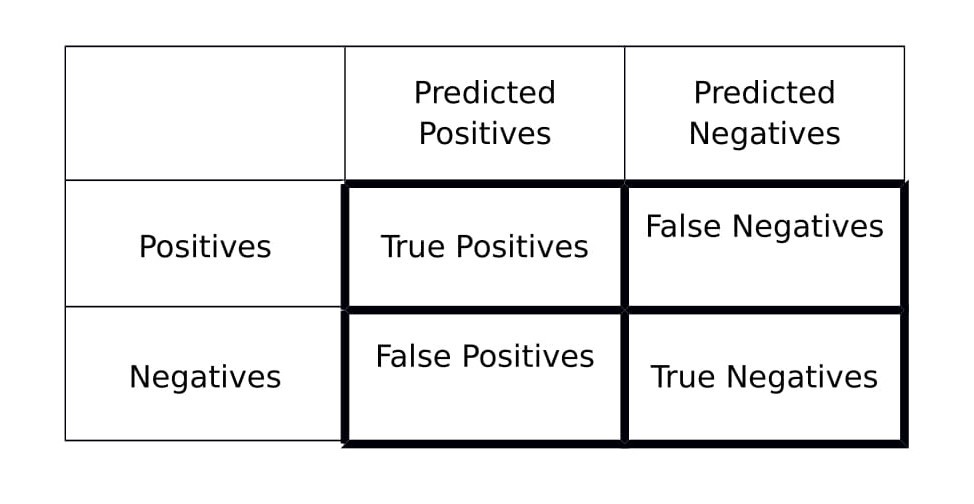

Elle nous permet de mieux comprendre les métriques suivantes

**Le recall**: Il permet d'obtenir un pourcentage de positifs correctement prédit.
Si ce dernier est élévé indique que le modèle ne se trompera que rarement sur les positifs
Il est définit par:

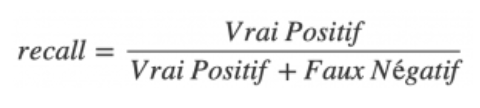

**Precision**: Elle permet de connaitre le nombre de prédictions positifs bien effectuées. (Nombre de positifs correctement prédit) divisé par l'ensemble des positifs prédit
Elevé il indique que le modèle minimise le nombre de faux positif


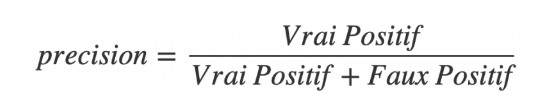

**F1 Score** (moyenne harmonique)

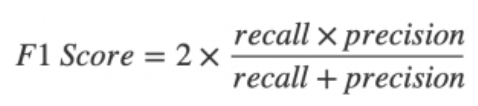

**Accuracy**: Elle permet de décrire les performances du modèle dans toutes les classes
(Nombre de prédiction correctes divisé par le nombre total de prédiction)

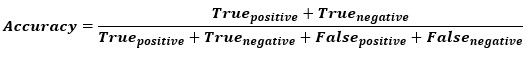

Bien revenons sur notre projet. Il n'est évident de calculer et d'évaluer des modèles de captionning.
Néanmoins quelques méthodes existent. Dans cette partie nous vous en présenterons une.

**BLEU score**

Imaginons une image représentant un chat sur un tapis.
Cette dernière possèderait plusieurs légende dans le dataset la décrivant.


1.   The cat is on the mat
2.   There is a cat on the mat

**Bleu unigram:**
Imaginons la prédiction suivante
"The the the the the the the"

Ici avec une présicion classique nous aurions 7/7, car en effet the est bien dans les légendes de références. Pourtant la prédiction n'est vraiment pas super.
Avec le BLEU score, ce dernier va réfléchir en fonction du nombre de fois ou le mot apparait.
Ici en prenant la légende 1 on peut dire que la prédiction possède une précision de 2/7, car le mot "the" apparait 2 fois dans la légende.

**Bleu score on bigrams**
Contrairement au précédent nous allons comparer la prédiction par groupe de mot plutot que mot à mot.
Imaginons la prédiction suivante
"The cat the cat on the mat"

Nous allons donc compter le nombre d'apparition de la liste suivante dans les légendes

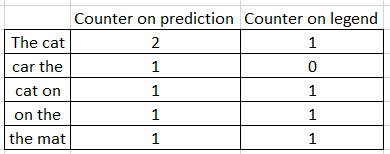

Nous pouvons donc ici calculer une précision de 4/6



### Imaginons un metrique

Nous pouvons également imaginer un dataset insistant sur les éléments importants des images commes des sujet importants de l'image

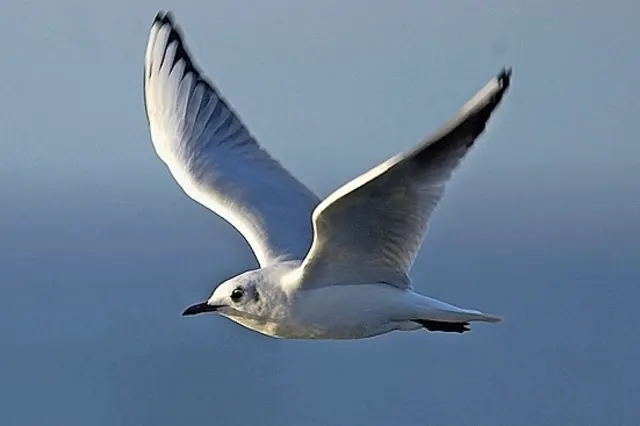

Nous pouvons imaginer une légende donnans des poids aux mots importants de l'image
Par exemple ici la légende pourrait etre
"Une mouette vole au dessus de l'eau"
et comme poids une valeure pour chaque mot qui une fois la somme effectué donnerais 100
[10, 50, 10, 5, 10, 2, 3, 10]
Ainsi si la prédiction n'obtient pas le mot mouette nous pourrons lui calculer une score faible.

# Conclusion
Nous avons pu voir que notre modèle était capable de prédire une annotation pour une image qu'il ne connait pas. Il peut arriver qu'il y ait des erreurs, comme des morceaux de phrases qui n'ont pas de sens, des mots inconnus [UNK], ou encore des problèmes de distinction d'objets.

Cependant, l'image arrive relativement bien à être annotée. La fonction de perte est faible. On peut donc penser que notre modèle est performant.

Après avoir fait quelques recherches, nous avons découvert deux techniques permettant de mesurer l'efficacité de notre modèle : Le Cemantix et les Métriques bleues.

Pour améliorer notre algorithme et l'aider à reconnaitre certains objets spécifiques, nous aurons besoin de le réentrainner avec un jeu de données spécifique à ces objets.